In [1]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from torchvision.models import inception_v3
#from data import load_dataset_and_make_dataloaders
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [2]:
from collections import namedtuple
from typing import Optional, Tuple

from torch.utils.data import default_collate, DataLoader, Dataset, random_split
from torchvision.datasets import CelebA, FashionMNIST
import torchvision.transforms as T


DataInfo = namedtuple('DataInfo', 'image_channels image_size num_classes sigma_data')
DataLoaders = namedtuple('DataLoaders', 'train valid')


def load_dataset_and_make_dataloaders(
        dataset_name: str,
        root_dir: str,
        batch_size: int,
        num_workers: int = 0,
        pin_memory: bool = False
    ) -> Tuple[DataLoaders, DataInfo]:

    train_dataset, valid_dataset, data_info = load_dataset(dataset_name, root_dir)
    dl = make_dataloaders(train_dataset, valid_dataset, data_info.num_classes, batch_size, num_workers, pin_memory)
    return dl, data_info


def load_dataset(dataset_name='FashionMNIST', root_dir='data') -> Tuple[Dataset, Dataset, DataInfo]:

    match dataset_name:

        case 'FashionMNIST':
            t = T.Compose([T.ToTensor(), T.Pad(2), T.Normalize(mean=(0.5,), std=(0.5,))])
            train_dataset = FashionMNIST(root_dir, download=True, transform=t)
            train_dataset, valid_dataset = random_split(train_dataset, [50000, 10000])
            #train_dataset, valid_dataset = random_split(train_dataset, [500, 59500])
            num_classes = 10

        case 'CelebA':
            t = T.Compose([T.ToTensor(), T.CenterCrop(178), T.Resize(128, antialias=True), T.Normalize(mean=(0.5,), std=(0.5,))])
            train_dataset = CelebA(root_dir, download=True, transform=t)
            train_dataset, valid_dataset = random_split(train_dataset, [150000, 12770])
            num_classes = None

        case other:
            raise RuntimeError('Unknown dataset: ' + other)

    #x, _ = next(iter(DataLoader(train_dataset, batch_size=100, shuffle=True)))
    x, _ = next(iter(DataLoader(train_dataset, batch_size=10000, shuffle=True)))
    _, c, h, w = x.size()
    assert h == w
    sigma_data = x.std()

    return train_dataset, valid_dataset, DataInfo(c, h, num_classes, sigma_data)


def make_dataloaders(
        train_dataset: Dataset,
        valid_dataset: Dataset,
        num_classes: Optional[int],
        batch_size: int,
        num_workers: int = 0,
        pin_memory: bool = False
    ) -> DataLoaders:

    collate_fn = default_collate if num_classes is not None else lambda batch: (default_collate(batch)[0], None)
    kwargs = {'collate_fn': collate_fn, 'num_workers': num_workers, 'persistent_workers': (num_workers > 0), 'pin_memory': pin_memory}

    return DataLoaders(
        train=DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs),
        valid=DataLoader(valid_dataset, batch_size=2 * batch_size, **kwargs)
    )


In [3]:
class Model(nn.Module):
    def __init__(
        self,
        image_channels: int,
        nb_channels: int,
        num_blocks: int,
        cond_channels: int,
    ) -> None:
        super().__init__()
        self.noise_emb = NoiseEmbedding(cond_channels)
        self.conv_in = nn.Conv2d(image_channels, nb_channels, kernel_size=3, padding=1)
        self.blocks = nn.ModuleList([
            ResidualBlock(nb_channels, cond_channels) for _ in range(num_blocks)
        ])
        self.conv_out = nn.Conv2d(nb_channels, image_channels, kernel_size=3, padding=1)

        # Apply custom initialization
        self._initialize_weights()

    def forward(self, noisy_input: torch.Tensor, c_noise: torch.Tensor) -> torch.Tensor:
        # Generate noise embedding
        cond = self.noise_emb(c_noise)  # [batch_size, cond_channels]

        # Pass through input convolution
        x = self.conv_in(noisy_input)

        # Pass through residual blocks with noise conditioning
        for block in self.blocks:
            x = block(x, cond)

        # Output convolution to return the denoised image
        return self.conv_out(x)

    def _initialize_weights(self):
        """Custom weight initialization."""
        # Initialize conv_out weights to 0
        nn.init.constant_(self.conv_out.weight, 0)
        if self.conv_out.bias is not None:
            nn.init.constant_(self.conv_out.bias, 0)




class NoiseEmbedding(nn.Module):
    """
    The NoiseEmbedding module generates a sinusoidal embedding for a given noise level.
    It takes a 1D tensor representing the noise level and produces a 2D tensor with
    concatenated cosine and sine values of the noise level scaled by a learned weight.

    This embedding can be used to condition the model on different noise levels, which
    is useful in tasks such as denoising or generative modeling where the noise level
    plays a significant role.
    """
    def __init__(self, cond_channels: int) -> None:
        super().__init__()
        assert cond_channels % 2 == 0
        self.register_buffer('weight', torch.randn(1, cond_channels // 2))

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        assert input.ndim == 1
        f = 2 * torch.pi * input.unsqueeze(1) @ self.weight
        return torch.cat([f.cos(), f.sin()], dim=-1)


class ResidualBlock(nn.Module):
    def __init__(self, nb_channels: int, cond_channels: int):
        super().__init__()
        self.norm1 = nn.BatchNorm2d(nb_channels, affine=False)
        self.conv1 = nn.Conv2d(nb_channels, nb_channels, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(nb_channels, affine=False)
        self.conv2 = nn.Conv2d(nb_channels, nb_channels, kernel_size=3, stride=1, padding=1)

        # Predict affine parameters
        self.gamma1 = nn.Linear(cond_channels, nb_channels)
        self.beta1 = nn.Linear(cond_channels, nb_channels)
        self.gamma2 = nn.Linear(cond_channels, nb_channels)
        self.beta2 = nn.Linear(cond_channels, nb_channels)

        # Apply custom initialization
        self._initialize_weights()

    def forward(self, x, cond):
        gamma1 = self.gamma1(cond).unsqueeze(-1).unsqueeze(-1)
        beta1 = self.beta1(cond).unsqueeze(-1).unsqueeze(-1)
        y = self.norm1(x)
        y = gamma1 * y + beta1
        y = F.leaky_relu(self.conv1(y), negative_slope=0.2)

        gamma2 = self.gamma2(cond).unsqueeze(-1).unsqueeze(-1)
        beta2 = self.beta2(cond).unsqueeze(-1).unsqueeze(-1)
        y = self.norm2(y)
        y = gamma2 * y + beta2
        y = F.leaky_relu(self.conv2(y), negative_slope=0.2)

        return x + y

    def _initialize_weights(self):
        """Custom weight initialization."""
        # Initialize conv2 weights to 0
        nn.init.constant_(self.conv2.weight, 0)
        if self.conv2.bias is not None:
            nn.init.constant_(self.conv2.bias, 0)




In [4]:

#Step 1.0: Sample an image y from the dataset:
gpu = torch.cuda.is_available()
device = torch.device('cuda:0' if gpu else 'cpu')

dl, info = load_dataset_and_make_dataloaders(
    dataset_name='FashionMNIST',
    root_dir='data', # choose the directory to store the data
    batch_size=256,
    num_workers=2,   # you can use more workers if you see the GPU is waiting for the batches
    pin_memory=True,  # use pin memory if you're planning to move the data to GPU
)
sigma_data = info.sigma_data.to(device)  # Move sigma_data to GPU
train_dl = dl.train
test_dl = dl.valid
#Step 1.1: Sample sigma from pnoise
def sample_sigma(n, loc=-1.2, scale=1.2, sigma_min=2e-3, sigma_max=80):
    return (torch.randn(n, device=device) * scale + loc).exp().clamp(sigma_min, sigma_max)


#Step 1.2: Add noise
def add_noise_to_image(image, sigma, p_noise_mean=0, p_noise_std=1):
    epsilon = torch.randn(image.shape, device=image.device) * p_noise_std + p_noise_mean
    noisy_image = image + sigma.view(-1, 1, 1, 1) * epsilon  # Ensure sigma is correctly broadcasted
    noisy_image = torch.clamp(noisy_image, -1, 1)  # Clamp to [-1, 1] to match normalization
    return noisy_image


#Step 1.3: Compute coefficients
def c_in(sigma):
    return 1/(torch.sqrt(sigma_data**2 + sigma**2))

def c_out(sigma):
    return sigma*sigma_data/(torch.sqrt(sigma_data**2 + sigma**2))

def c_skip(sigma):
    return sigma_data**2/(sigma_data**2 + sigma**2)

def c_noise(sigma):
    return torch.log(sigma)/4
"""
train_target = []
sigma_batch = []
noisy_train_input = []
s = True
for images, _ in train_dl:
    images = images.to(device)  # Move images to GPU
    if s:
        batch_siz = images.shape[0]
        s = False
    #For each batch, a different sigma
    sigma = sample_sigma(1).to(device)  # Ensure sigma is on GPU
    sigma_batch.append(sigma)
    for sub_image in images:
        noised_image = add_noise_to_image(sub_image, sigma)
        noisy_train_input.append(noised_image * c_in(sigma))
        train_target.append((sub_image - c_skip(sigma) * noised_image) / c_out(sigma))

noisy_train_input = torch.stack(noisy_train_input).float().to(device)  # Move to GPU
train_target = torch.stack(train_target).float().to(device)  # Move to GPU
sigma_batch = torch.stack(sigma_batch).float().to(device)  # Move to GPU
c_noise_list = c_noise(sigma_batch).to(device)  # Move to GPU

train_dataset = TensorDataset(noisy_train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size=batch_siz, shuffle=False)
"""
noisy_test_input = []
for images, _ in test_dl:
    images = images.to(device)  # Move images to GPU
    for sub_image in images:
        #For each image, a different sigma, not storing the sigma this time
        sigma = sample_sigma(1).to(device)  # Ensure sigma is on GPU
        noised_image = add_noise_to_image(sub_image, sigma)
        noisy_test_input.append(noised_image)
noisy_test_input = torch.stack(noisy_test_input).float().to(device)  # Move to GPU


In [5]:
# Define the gradient scaler for mixed precision
scaler = GradScaler(device='cuda')

def has_nan_or_inf(tensor, name="Tensor"):
    if torch.isnan(tensor).any():
        print(f"{name} contains NaN.")
        return True
    if torch.isinf(tensor).any():
        print(f"{name} contains Inf.")
        return True
    return False

def add_noise_batch(images, sigma, noise_mean=0, noise_std=1):
    epsilon = torch.randn_like(images) * noise_std + noise_mean
    noisy_images = images + sigma.view(-1, 1, 1, 1) * epsilon
    return torch.clamp(noisy_images, -1, 1)

eta = 0.005
image_channels = 1  # FashionMNIST images have 1 channel
nb_channels = 128  # Number of channels
num_blocks = 8  # Number of residual blocks
cond_channels = 64  # Number of conditioning channels
model = Model(image_channels, nb_channels, num_blocks, cond_channels).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

# Training loop with mixed precision
nb_epochs = 50
torch.autograd.set_detect_anomaly(False)

for epoch in tqdm(range(nb_epochs), desc="Training"):
    # --- Training Phase ---
    model.train()
    total_train_loss = 0
    for images, _ in train_dl:
        images = images.to(device)  # Move images to GPU
        batch_size = images.size(0)

        # Sample sigma per image
        sigma = sample_sigma(batch_size).to(device)
        noised_images = add_noise_batch(images, sigma)

        # Compute coefficients
        c_in_values = c_in(sigma).view(-1, 1, 1, 1)
        c_out_values = c_out(sigma).view(-1, 1, 1, 1)
        c_skip_values = c_skip(sigma).view(-1, 1, 1, 1)
        c_noise_values = c_noise(sigma)

        # Prepare inputs and targets
        x_batch = noised_images * c_in_values
        t_batch = (images - c_skip_values * noised_images) / c_out_values

        # Zero the gradients
        optimizer.zero_grad()

        # Forward and backward passes with mixed precision
        with autocast(device_type='cuda'):  # Enable mixed precision for this block
            output = model(x_batch, c_noise_values)
            loss = criterion(output, t_batch)

        # Scale the loss for mixed precision
        scaler.scale(loss).backward()

        # Update weights using scaled gradients
        scaler.step(optimizer)

        # Update the scale for the next iteration
        scaler.update()

        # Accumulate training loss
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dl)

    # --- Validation Phase ---
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for images, _ in test_dl:
            images = images.to(device)  # Move images to GPU
            batch_size = images.size(0)

            # Sample sigma per image
            sigma = sample_sigma(batch_size).to(device)
            noised_images = add_noise_batch(images, sigma)

            # Compute coefficients
            c_in_values = c_in(sigma).view(-1, 1, 1, 1)
            c_out_values = c_out(sigma).view(-1, 1, 1, 1)
            c_skip_values = c_skip(sigma).view(-1, 1, 1, 1)
            c_noise_values = c_noise(sigma)

            # Prepare inputs and targets
            x_batch = noised_images * c_in_values
            t_batch = (images - c_skip_values * noised_images) / c_out_values

            # Forward pass with mixed precision
            with autocast(device_type='cuda'):  # Enable mixed precision for this block
                output = model(x_batch, c_noise_values)
                loss = criterion(output, t_batch)

            # Accumulate validation loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_dl)

    # Update the scheduler based on validation loss
    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{nb_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


Training:   2%|▏         | 1/50 [01:26<1:10:35, 86.44s/it]

Epoch [1/50], Training Loss: 13.2997, Validation Loss: 0.4792


Training:   4%|▍         | 2/50 [02:51<1:08:18, 85.39s/it]

Epoch [2/50], Training Loss: 0.4529, Validation Loss: 0.4312


Training:   6%|▌         | 3/50 [04:15<1:06:31, 84.92s/it]

Epoch [3/50], Training Loss: 0.4143, Validation Loss: 0.3903


Training:   8%|▊         | 4/50 [05:39<1:04:54, 84.66s/it]

Epoch [4/50], Training Loss: 0.3594, Validation Loss: 0.3378


Training:  10%|█         | 5/50 [07:04<1:03:28, 84.63s/it]

Epoch [5/50], Training Loss: 0.3136, Validation Loss: 0.2933


Training:  12%|█▏        | 6/50 [08:28<1:01:58, 84.52s/it]

Epoch [6/50], Training Loss: 0.2741, Validation Loss: 0.2667


Training:  14%|█▍        | 7/50 [09:52<1:00:32, 84.47s/it]

Epoch [7/50], Training Loss: 0.2531, Validation Loss: 0.2433


Training:  16%|█▌        | 8/50 [11:17<59:09, 84.50s/it]  

Epoch [8/50], Training Loss: 0.2400, Validation Loss: 0.2636


Training:  18%|█▊        | 9/50 [12:41<57:42, 84.46s/it]

Epoch [9/50], Training Loss: 0.2296, Validation Loss: 0.2261


Training:  20%|██        | 10/50 [14:06<56:19, 84.48s/it]

Epoch [10/50], Training Loss: 0.2218, Validation Loss: 0.2242


Training:  22%|██▏       | 11/50 [15:31<54:57, 84.55s/it]

Epoch [11/50], Training Loss: 0.2169, Validation Loss: 0.2126


Training:  24%|██▍       | 12/50 [16:55<53:34, 84.60s/it]

Epoch [12/50], Training Loss: 0.2145, Validation Loss: 0.2207


Training:  26%|██▌       | 13/50 [18:20<52:14, 84.72s/it]

Epoch [13/50], Training Loss: 0.2094, Validation Loss: 0.2179


Training:  28%|██▊       | 14/50 [19:45<50:51, 84.76s/it]

Epoch [14/50], Training Loss: 0.2034, Validation Loss: 0.2008


Training:  30%|███       | 15/50 [21:10<49:28, 84.80s/it]

Epoch [15/50], Training Loss: 0.2018, Validation Loss: 0.2005


Training:  32%|███▏      | 16/50 [22:35<48:04, 84.84s/it]

Epoch [16/50], Training Loss: 0.2012, Validation Loss: 0.2033


Training:  34%|███▍      | 17/50 [24:00<46:41, 84.89s/it]

Epoch [17/50], Training Loss: 0.1990, Validation Loss: 0.2046


Training:  36%|███▌      | 18/50 [25:25<45:17, 84.92s/it]

Epoch [18/50], Training Loss: 0.1956, Validation Loss: 0.1932


Training:  38%|███▊      | 19/50 [26:50<43:52, 84.92s/it]

Epoch [19/50], Training Loss: 0.1953, Validation Loss: 0.1971


Training:  40%|████      | 20/50 [28:15<42:30, 85.00s/it]

Epoch [20/50], Training Loss: 0.1948, Validation Loss: 0.1932


Training:  42%|████▏     | 21/50 [29:40<41:06, 85.04s/it]

Epoch [21/50], Training Loss: 0.1922, Validation Loss: 0.1918


Training:  44%|████▍     | 22/50 [31:06<39:45, 85.19s/it]

Epoch [22/50], Training Loss: 0.1928, Validation Loss: 0.1929


Training:  46%|████▌     | 23/50 [32:31<38:20, 85.21s/it]

Epoch [23/50], Training Loss: 0.1917, Validation Loss: 0.1927


Training:  48%|████▊     | 24/50 [33:56<36:55, 85.23s/it]

Epoch [24/50], Training Loss: 0.1906, Validation Loss: 0.1896


Training:  50%|█████     | 25/50 [35:22<35:32, 85.31s/it]

Epoch [25/50], Training Loss: 0.1903, Validation Loss: 0.1920


Training:  52%|█████▏    | 26/50 [36:47<34:07, 85.32s/it]

Epoch [26/50], Training Loss: 0.1905, Validation Loss: 0.1960


Training:  54%|█████▍    | 27/50 [38:13<32:42, 85.33s/it]

Epoch [27/50], Training Loss: 0.1901, Validation Loss: 0.1899


Training:  56%|█████▌    | 28/50 [39:38<31:17, 85.34s/it]

Epoch [28/50], Training Loss: 0.1897, Validation Loss: 0.1894


Training:  58%|█████▊    | 29/50 [41:03<29:52, 85.34s/it]

Epoch [29/50], Training Loss: 0.1900, Validation Loss: 0.1890


Training:  60%|██████    | 30/50 [42:29<28:28, 85.42s/it]

Epoch [30/50], Training Loss: 0.1891, Validation Loss: 0.1904


Training:  62%|██████▏   | 31/50 [43:54<27:02, 85.40s/it]

Epoch [31/50], Training Loss: 0.1894, Validation Loss: 0.1900


Training:  64%|██████▍   | 32/50 [45:20<25:38, 85.47s/it]

Epoch [32/50], Training Loss: 0.1879, Validation Loss: 0.1874


Training:  66%|██████▌   | 33/50 [46:45<24:12, 85.44s/it]

Epoch [33/50], Training Loss: 0.1883, Validation Loss: 0.1889


Training:  68%|██████▊   | 34/50 [48:11<22:47, 85.47s/it]

Epoch [34/50], Training Loss: 0.1878, Validation Loss: 0.1886


Training:  70%|███████   | 35/50 [49:36<21:22, 85.50s/it]

Epoch [35/50], Training Loss: 0.1869, Validation Loss: 0.1871


Training:  72%|███████▏  | 36/50 [51:02<19:57, 85.54s/it]

Epoch [36/50], Training Loss: 0.1877, Validation Loss: 0.1880


Training:  74%|███████▍  | 37/50 [52:27<18:31, 85.52s/it]

Epoch [37/50], Training Loss: 0.1874, Validation Loss: 0.1899


Training:  76%|███████▌  | 38/50 [53:53<17:06, 85.51s/it]

Epoch [38/50], Training Loss: 0.1869, Validation Loss: 0.1870


Training:  78%|███████▊  | 39/50 [55:18<15:40, 85.50s/it]

Epoch [39/50], Training Loss: 0.1864, Validation Loss: 0.1871


Training:  80%|████████  | 40/50 [56:44<14:15, 85.52s/it]

Epoch [40/50], Training Loss: 0.1876, Validation Loss: 0.1870


Training:  82%|████████▏ | 41/50 [58:10<12:49, 85.55s/it]

Epoch [41/50], Training Loss: 0.1867, Validation Loss: 0.1888


Training:  84%|████████▍ | 42/50 [59:36<11:25, 85.68s/it]

Epoch [42/50], Training Loss: 0.1868, Validation Loss: 0.1889


Training:  86%|████████▌ | 43/50 [1:01:01<10:00, 85.73s/it]

Epoch [43/50], Training Loss: 0.1864, Validation Loss: 0.1856


Training:  88%|████████▊ | 44/50 [1:02:27<08:34, 85.71s/it]

Epoch [44/50], Training Loss: 0.1876, Validation Loss: 0.1866


Training:  90%|█████████ | 45/50 [1:03:53<07:08, 85.73s/it]

Epoch [45/50], Training Loss: 0.1866, Validation Loss: 0.1863


Training:  92%|█████████▏| 46/50 [1:05:19<05:42, 85.73s/it]

Epoch [46/50], Training Loss: 0.1860, Validation Loss: 0.1872


Training:  94%|█████████▍| 47/50 [1:06:44<04:17, 85.79s/it]

Epoch [47/50], Training Loss: 0.1878, Validation Loss: 0.1871


Training:  96%|█████████▌| 48/50 [1:08:11<02:51, 85.88s/it]

Epoch [48/50], Training Loss: 0.1875, Validation Loss: 0.1882


Training:  98%|█████████▊| 49/50 [1:09:36<01:25, 85.89s/it]

Epoch [49/50], Training Loss: 0.1870, Validation Loss: 0.1869


Training: 100%|██████████| 50/50 [1:11:03<00:00, 85.26s/it]

Epoch [50/50], Training Loss: 0.1873, Validation Loss: 0.1870


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Generating Images: 100%|██████████| 20/20 [00:47<00:00,  2.35s/it]


FID score: 145.0048502717662


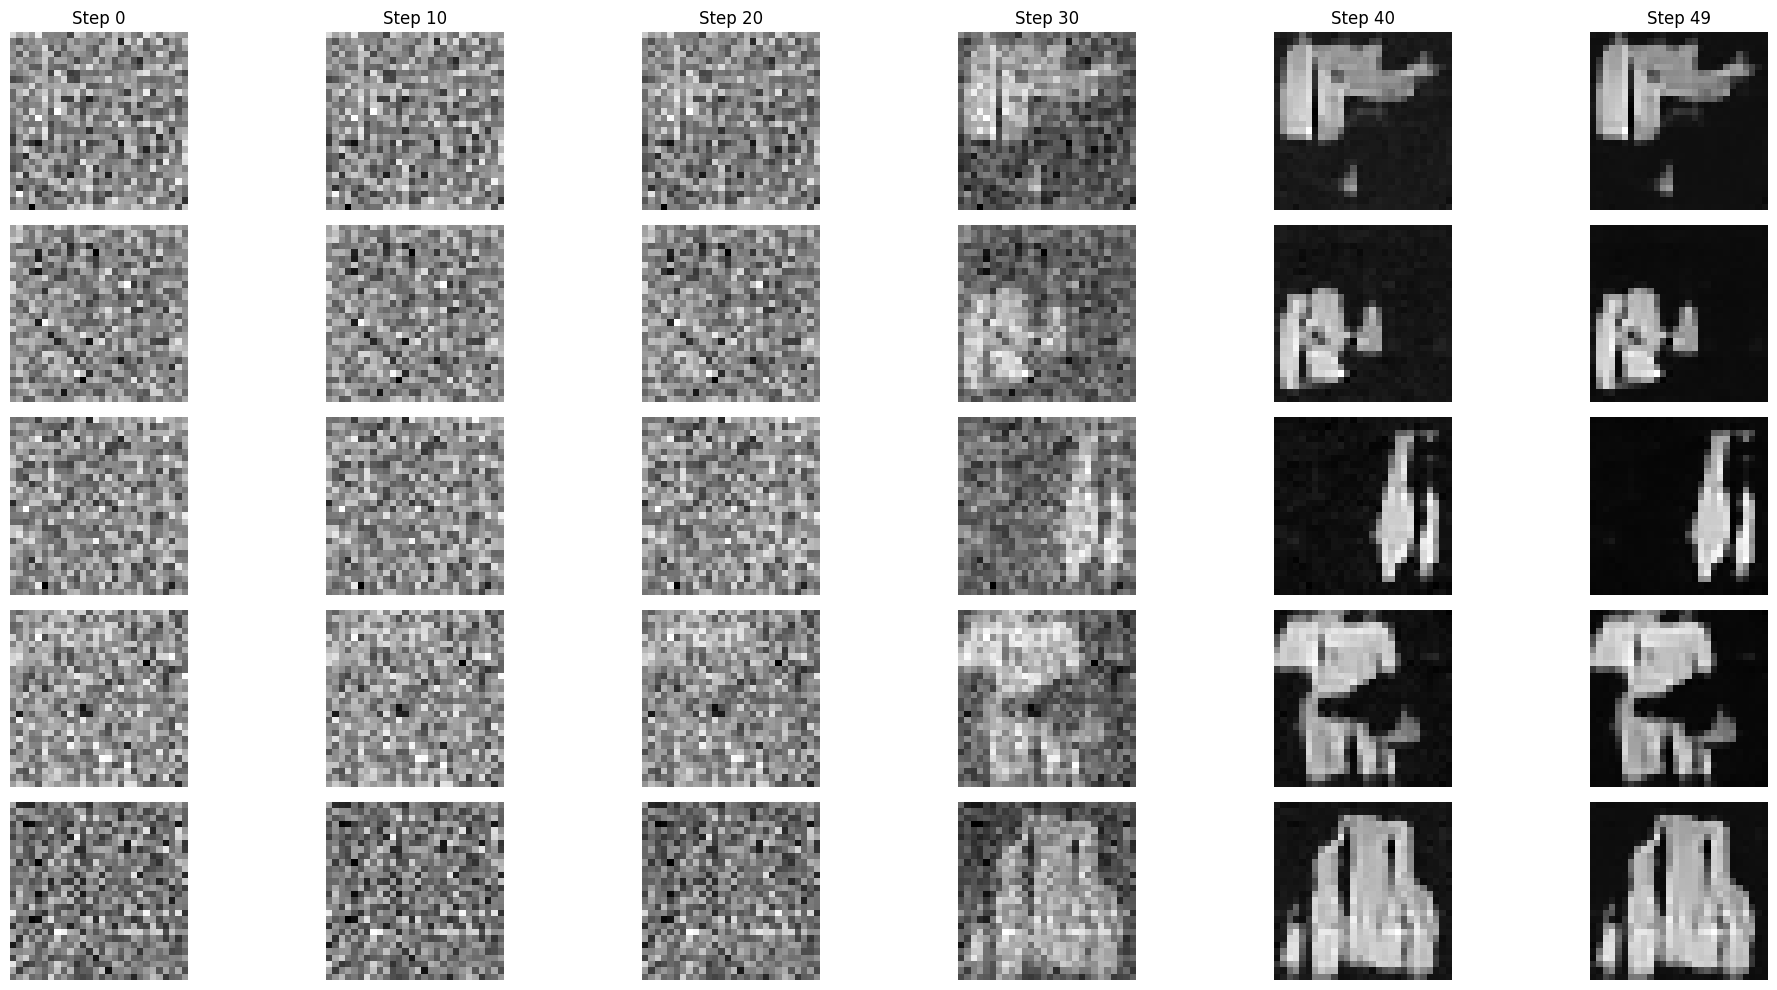

In [6]:
# Step 1: Set up InceptionV3 model
# Load pre-trained InceptionV3 model
inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
inception_model.fc = nn.Identity()  # Remove the final classification layer
inception_model.eval()  # Set the model to evaluation mode

# Define a transformation to convert 1-channel to 3-channel and resize to 299x299
preprocess = T.Compose([
    T.Resize((299, 299)),
    T.Lambda(lambda x: x.repeat(1, 3, 1, 1) if x.size(1) == 1 else x),  # Ensure 3 channels
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

def get_inception_features(images, model, device, preprocess, batch_size=50):
    """
    Extract features from images using the InceptionV3 model.

    Args:
        images (torch.Tensor): Tensor of images with shape (N, C, H, W).
        model (nn.Module): Pretrained InceptionV3 model.
        device (torch.device): Computing device.
        preprocess (callable): Preprocessing function.
        batch_size (int): Batch size for processing images.

    Returns:
        np.ndarray: Extracted features of shape (N, feature_dim).
    """
    features = []
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].to(device)
            # Convert from [-1, 1] to [0, 1]
            batch = (batch + 1) / 2
            batch = preprocess(batch)
            outputs = model(batch)
            features.append(outputs.cpu().numpy())
    features = np.concatenate(features, axis=0)
    return features

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2):
    """Calculate the Frechet Distance between two multivariate Gaussians."""
    diff = mu1 - mu2
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = np.sum(diff ** 2) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid


# Testing loop
model.eval()

def sample_initial_noise(shape, sigma):
    return torch.randn(shape, device=sigma.device) * sigma

def build_sigma_schedule(steps, rho=7, sigma_min=2e-3, sigma_max=80):
    min_inv_rho = sigma_min ** (1 / rho)
    max_inv_rho = sigma_max ** (1 / rho)
    sigmas = (max_inv_rho + torch.linspace(0, 1, steps) * (min_inv_rho - max_inv_rho)) ** rho
    return sigmas

# Create a sequence of decreasing sigmas
sigmas = build_sigma_schedule(steps=50).to(device)

# Sample initial Gaussian noise with standard deviation sigmas[0]
initial_sigma = sigmas[0]
initial_noise = sample_initial_noise((5, 1, 28, 28), initial_sigma).to(device)  # Batch of 5 images

# Define the denoising function using Euler's method
def D(x, sigma):
    c_skip_sigma = c_skip(sigma).view(-1, 1, 1, 1)
    c_out_sigma = c_out(sigma).view(-1, 1, 1, 1)
    c_in_sigma = c_in(sigma).view(-1, 1, 1, 1)
    c_noise_sigma = c_noise(sigma)  # [batch_size]
    return c_skip_sigma * x + c_out_sigma * model(c_in_sigma * x, c_noise_sigma)

sigmas = build_sigma_schedule(50).to(device)  # Ensure sigmas are on GPU

def euler_step(x, sigmas, save_steps=None):
    batch_size = x.size(0)
    intermediate_images = [[] for _ in range(batch_size)]  # List of lists to store intermediate images for each image
    for i, sigma in enumerate(sigmas):
        sigma = sigma.to(x.device)
        sigma = sigma.expand(batch_size)  # Shape: [batch_size]
        with torch.no_grad():
            x_denoised = D(x, sigma)

        if i < len(sigmas) - 1:
            sigma_next = sigmas[i + 1].to(x.device)
            sigma_next = sigma_next.expand(batch_size)
        else:
            sigma_next = torch.full((batch_size,), 2e-3, device=x.device)  # sigma_min

        d = (x - x_denoised) / (sigma.view(-1, 1, 1, 1))

        sigma_diff = (sigma_next - sigma).view(-1, 1, 1, 1)
        x = x + d * sigma_diff

        # Save intermediate images if specified
        if save_steps and i in save_steps:
            for j in range(batch_size):
                intermediate_images[j].append(x[j].clone().cpu())

    return x, intermediate_images

def generate_images(sigmas, num_images=1000, batch_size=50, save_steps=None):
    """
    Generate a specified number of images using the diffusion model.

    Args:
        sigmas (torch.Tensor): Schedule of sigma values.
        num_images (int): Total number of images to generate.
        batch_size (int): Number of images per batch.
        save_steps (list, optional): Steps at which to save intermediate images.

    Returns:
        torch.Tensor: Generated images with shape [num_images, 1, 28, 28].
    """
    model.eval()
    generated_images = []
    num_batches = num_images // batch_size
    for _ in tqdm(range(num_batches), desc="Generating Images"):
        initial_sigma = sigmas[0]
        initial_noise = sample_initial_noise((batch_size, 1, 28, 28), initial_sigma).to(device)
        denoised_batch, _ = euler_step(initial_noise, sigmas, save_steps=save_steps)
        generated_images.append(denoised_batch.cpu())
    return torch.cat(generated_images, dim=0)  # Shape: [num_images, 1, 28, 28]

def get_real_images(train_loader, num_images=1000):
    """
    Extract a subset of real images from the training loader.

    Args:
        train_loader (DataLoader): DataLoader for the training dataset.
        num_images (int): Number of real images to extract.

    Returns:
        torch.Tensor: Real images with shape [num_images, 1, 28, 28].
    """
    real_images = []
    for batch in train_loader:
        images, _ = batch
        real_images.append(images)
        if len(torch.cat(real_images, dim=0)) >= num_images:
            break
    real_images = torch.cat(real_images, dim=0)[:num_images]
    return real_images

# Extract real images using your existing DataLoader 'train_dl'
real_images = get_real_images(train_dl, num_images=1000).to(device)  # Shape: [1000, 1, 28, 28]

# Generate images using your existing variables
generated_images = generate_images(sigmas,num_images=1000, batch_size=50, save_steps=None)  # Shape: [1000, 1, 28, 28]

# Convert images from [-1, 1] to [0, 1]
real_images = (real_images + 1) / 2
generated_images = (generated_images + 1) / 2

# Extract Inception features for real and generated images
real_features = get_inception_features(real_images, inception_model, device, preprocess, batch_size=50)  # Shape: [1000, D]
generated_features = get_inception_features(generated_images, inception_model, device, preprocess, batch_size=50)  # Shape: [1000, D]

# Compute statistics
mu_real = np.mean(real_features, axis=0)
sigma_real = np.cov(real_features, rowvar=False)
mu_gen = np.mean(generated_features, axis=0)
sigma_gen = np.cov(generated_features, rowvar=False)

# Compute FID score
fid_score = calculate_frechet_distance(mu_real, sigma_real, mu_gen, sigma_gen)
print(f'FID score: {fid_score}')
# Apply the denoising network iteratively using Euler's method
save_steps = [0, 10, 20, 30, 40, 49]  # Specify steps to save intermediate images
_, intermediate_images = euler_step(initial_noise, sigmas, save_steps=save_steps)

# Visualize the intermediate denoising process for 5 different images
fig, axes = plt.subplots(5, len(save_steps), figsize=(20, 10))
for i in range(5):
    for j, step in enumerate(save_steps):
        axes[i, j].imshow(intermediate_images[i][j].squeeze().numpy(), cmap='gray')
        if i == 0:
            axes[i, j].set_title(f"Step {step}")
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()